time
1     3594.173049
2     5500.056602
3     2463.579979
4      838.139075
5      995.284896
6     1458.637339
7     1698.573493
8     2195.066063
9     4844.567199
10    2549.708730
11    2187.751041
12    1068.754690
13    1741.613314
14    5112.676142
15    2340.444561
16    1740.822527
17    3018.306599
18    1091.964859
19    3091.281213
20    1713.237863
21    3990.166798
22    4275.460085
23    2145.356611
24    1920.462532
25     798.811746
26    3249.521533
27    6512.188158
28    3648.325229
29    5842.456594
30    3072.645825
31    5182.985993
Name: 10473, dtype: float64


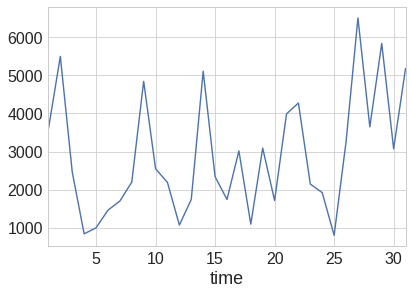

In [16]:
import os
#import ipdb

import pandas as pd
import matplotlib as mpl
from matplotlib import lines
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

EXP_NAME = "logs"

MAX_ROUNDS = 70
MAX_YVAL = 5

RESULTS_DIR = os.path.join( os.getcwd(),'results')

headers = ['time', 'elapsed', 'remotehost', 'code/status','bytes','method','URL','rfc931', 'peerstatus/peerhost','type'] 
dtypes = [pd.datetime, float, float]

##SET SEABORN STYLE
sns.set_style("whitegrid")
sns.set_context("paper")

##SET MATPLOTLIB STYLE
TICKS_FONTSIZE = 16
LABEL_FONTSIZE=18
LEGEND_FONTSIZE=15
linestyles = (':','-','.','--')

mpl.rcParams['xtick.labelsize'] = TICKS_FONTSIZE 
mpl.rcParams['ytick.labelsize'] = TICKS_FONTSIZE
mpl.rcParams['legend.fontsize'] = TICKS_FONTSIZE
mpl.rcParams['axes.labelsize'] = LABEL_FONTSIZE
mpl.rcParams['axes.titlesize'] = LABEL_FONTSIZE
mpl.rcParams['font.size'] = LABEL_FONTSIZE
plt.rc('legend',**{'fontsize':LEGEND_FONTSIZE})


#Read input files from the directory and returns DataTable object in a combined list
def read_inputs():
    #Get list of nodes(files) with results
    INPUT_DIR = os.path.join( os.getcwd(), EXP_NAME)
    dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, f))]
    #Load results from each node
    nodes_results = {}
    for sub_dir in dirs:
        nodes = [f for f in os.listdir(INPUT_DIR+'/'+sub_dir) if os.path.isfile(os.path.join(INPUT_DIR+'/'+sub_dir, f))]
        for node in nodes:
            file = os.path.join(INPUT_DIR+'/'+sub_dir,node)
            try:
                temp = pd.read_csv(file, sep=' ', header=None)
                temp.columns = headers
                temp['time'] = pd.to_datetime(temp['time'], unit='s')
                temp.set_index('time')
                if sub_dir in nodes_results:
                    nodes_results[sub_dir] = pd.concat([nodes_results[sub_dir], temp])
                else:
                    nodes_results[sub_dir] = temp                    
            except Exception:
                print(node, 'EXception')
    return nodes_results

def plot_bytes_per_round(results, var):
    """Plot the median acrros nodes of a variable"""
    #getMedianDF(results, var)
    median = getMedianDF(results,var)
    #Create new figure
    #fig = plt.figure()
    #Print the plot
    #print(median)
    median.plot()
    #Modify parameters
    #plt.ylabel(var)
    #plt.xlabel('Date')
    #plt.ylim(0,100)
    plt.show()
    
############################### HELPERS  ##############################
#######################################################################

def getMedianDF(nodes_results,var):
    series = []
    total=0
    count=0
    for name,r in nodes_results.items():
        #Normalize duplicate rounds
        times = pd.to_datetime(r['time'])
        s = r.groupby([times.dt.day]).sum()[var]/1000000
        s.name = name
        series.append(s)
    df = pd.concat(series,axis=0)    
    print(df)
    return df



def getECDF(df):
    """Helper function that caclulates the ECDF of a
    dataframe"""
    df = df.sort_values().value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()
    return ecdf
    

if __name__ == '__main__':
    nodes = read_inputs()
    plot_bytes_per_round(nodes,'bytes')